В этом блокноте будут рассмотрены принципы модуляции и демодуляции синтезированных сигналов. Работа с сигналами будет происходить в комплексной форме.

In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from matplotlib import pyplot as plt
from itertools import zip_longest
from scipy import signal

%matplotlib inline

def sinus(freq, framerate):
    xt = np.linspace(0, 1, framerate)

    return xt, np.sin(2 * np.pi * freq * xt)

def cosinus(freq, framerate):
    xt = np.linspace(0, 1, framerate)

    return xt, np.cos(2 * np.pi * freq * xt)

def sinus_complex(freq, framerate):
    xt = np.linspace(0, 1, framerate)

    y = [complex(r, i) for r, i in zip_longest(np.cos(2 * np.pi * freq * xt), np.sin(2 * np.pi * freq * xt))]

    return xt, y

def fft_display(y, sr = None, slc = None):
    """
        Параметры:
        ==========

        y - входные данные

        sr - частота дискретизации в герцах

        slc - кортеж индексов для слайсинга (number, number)

        Примечание:
        ===========

        Если не указана частота дискретизации то она будет равна длине входного массива
    """

    if sr is None:
        sr = y.size

    fft = (2 /y.size) * np.abs(rfft(y))
    mask = rfftfreq(y.size, 1/sr)

    if slc is None:
        plt.plot(mask, fft)
    else:
        s = slc[0]
        e = slc[1]

        plt.plot(mask[s:e], fft[s:e])

Начало амплитудной модуляции. Определим функцию производящую модуляцию, затем сгенерируем сигналы огибающей и несущей частоты и промодулируем.

In [484]:
carrier_freq = 100 # частота несущей
signal_freq = 10 # частота огибающей
sample_rate = carrier_freq * 10 # частота дискретизации

dt, y_carrier = sinus(carrier_freq, sample_rate) # отсчеты несущей частоты
_, y_signal = sinus(signal_freq, sample_rate) # отсчеты огибающего сигнала

def am_modulate(carrier, signal, coef, magnitude = 1):
    """
        Параметры:
        ==========

        carrier - Готовые отсчеты несущей sin/cos(2 * pi * freq + phi)

        signal - Готовые отсчеты огибающей sin/cos(2 * pi * freq + phi)

        coef - Коэффициент модуляции [0...1]

        magnitude - Амплитуда сигнала

        Выходные данные
        ===============

        mod - Промодулированный сигнал (A0 * [1 + coef * u(t)] * uc(t))
        uc - отсчеты несущей частоты
        u - нормированные отсчеты огибающей
        coef - коэффициент модуляции
        A0 - амплитуда

        Примечение
        ==========

        Функция работает с уже сгенерированными сигналами несущей и огибающей частоты
    """
    signal_norm = signal/np.abs(np.max(signal))

    mod = magnitude * (1 + coef * signal_norm) * carrier

    return mod

y_input = am_modulate(y_carrier, y_signal, 0.5) # модулируем несущую с помощью огибающей

Выведем график полученного промодулированного АМ сигнала. На графике видно как передаваемый сигнал (огибающая) буквально огибает амплитуду несущего сигнала.

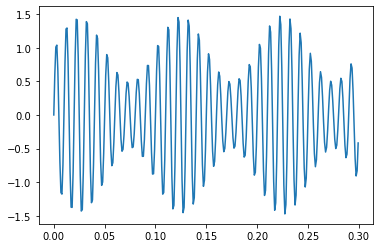

In [483]:
plt.plot(dt[:300], y_input[:300])

Выведем спектр модулированного сигнала. На спектре видны пики. В обычной АМ модуляции есть центральный пик - это несущая и два боковых пика смещенные от несущей на +- частоту огибающей.

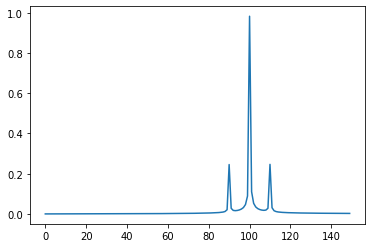

In [493]:
fft_display(y_input, sample_rate, (0, 150))

Рассмотрим способ в котором демодуляция АМ сигнала будет просходить в несколько этапов:
- Смещение спектра сигнала на нулевую частоту (по сути тут уже убрана несущая и остается огибающая)
- Избавление от постоянной составляющей

In [501]:
# Генерируем частоту гетеродина, отсчеты в комплексной форме. Частота равна частоте интересующего сигнала
_, geterodyne_am = sinus_complex(carrier_freq, sample_rate) 


# этап 1 - смешиваем сигналы гетеродина и АМ (смещаем спектр)
zero_am = geterodyne_am * y_input

# Выходной фильтр, т.к. после смещения спектра, сигнал интересющей нас частоты будет доступен на двух частотах (fсигн +- fгет)   
wn = 2 * 100 / sample_rate 
b, a = signal.butter(8, wn, "lowpass")

# фильтруем отдельно мнимую и вещественную часть
i = signal.filtfilt(b, a, zero_am.real)
q = signal.filtfilt(b, a, zero_am.imag)

# Получаем действительную часть сигнала из комплексной формы
real = np.sqrt(np.power(i, 2) + np.power(q, 2))

# этап 2 - убираем постоянную составляющую
real -= np.mean(real)

После демодулирования АМ сигнала посмотрим на полченный результат. Выведем спектр полченного сигнала. На спектре видно, что находится на частоте которая определена выше. Амплитуда сигнала страдает по двум причинам - коэффициент модуляции и особенности АМ модуляции. Умножив на 4 мы получаем исходное значение амплитуды

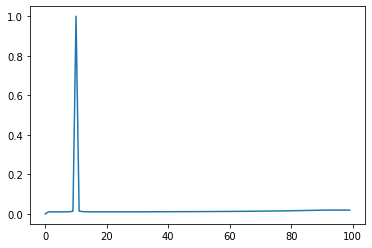

In [502]:
fft_display(real * 4, sample_rate, (0,100))

Выведем график полученного сигнала

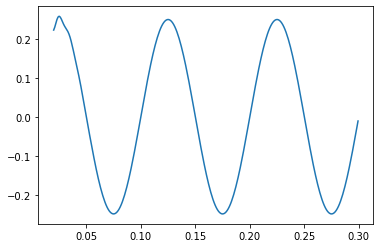

In [503]:

plt.plot(dt[20:300], real[20:300])


Рассмотрим модуляцию ЧМ сигнала. Модуляция происходит по слудующему закону
y(t) = A * cos(w_carrier + u(t) * w_deviate * coeff)

Где:
A - амплитуда
w_carrier - угловая частота несущей (2 * pi * f_carrier)
w_deviate - угловая частота девиации (2 * pi * f_deviate)
coeff - коэффициент девиации
u(t) - нормированный модулированный сигнал (интеграл от входного сигнала - sum(y/dt)) 

Девиация - отклонение частоты от несущей

In [5]:
carrier_fm_freq = 1000
sample_rate_fm = carrier_fm_freq * 10
signal_fm_freq = 100
deviation_fm = 100

dt_fm, y_fm_signal = sinus(signal_fm_freq, sample_rate_fm)


def fm_modulate(y, f, d, sr, coef = 1, a = 1):
    w_s = 2 * np.pi * f * np.linspace(0, 1, sr)
    w_d = 2 * np.pi * d

    def _norm(y, sr):
        integral = 0

        for i in y:
            integral += i / sr

            yield integral

    return a * np.sin(w_s + coef * w_d * np.array(list(_norm(y, sr))))

y_fm = fm_modulate(y_fm_signal, carrier_fm_freq, deviation_fm, sample_rate_fm, 1)

Посмотрим на полученный сигнал промодулированный с помощью ЧМ 
- несущая 1000 Гц
- частота девиации 100 Гц
- коэффициент девиации 1

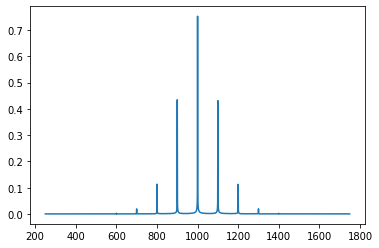

In [6]:
fft_fm = (2 / sample_rate_fm) * np.abs(rfft(y_fm))
mask_fm = rfftfreq(y_fm.size, 1/sample_rate_fm)

plt.plot(mask_fm[250:1750], fft_fm[250:1750])

Отобразим график полученного модулированного сигнала

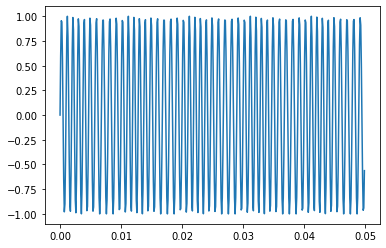

In [7]:
plt.plot(dt_fm[:500], y_fm[:500])

Начнем демодулировать сигнал. Демодуляция с использованием комплексных чисел состоит из этапов:
- смещение на нулевую частоту
- вычисление полной фазы сигнала
- устранение разрыва фазы сигнала
- интеграл от комплексной огибающей
- нормировка амплитуды

In [8]:
_, geterodyne_fm = sinus_complex(carrier_fm_freq, sample_rate_fm)

zero_fm = geterodyne_fm * y_fm

Посмотрим на спектр смещенного сигнала на нулевую частоту. Видно что сигнал сместился на нулевую частоту и если отобразить вторую половину спектра, то увидим оставшуюся боковую частоту. Также на спектре виден второй сигнал на сумме частот сигнала и гетеродина. 

C:\Users\alkir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\fft\_pocketfft.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


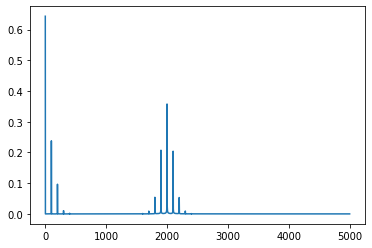

In [9]:
fft_fm_zero = (2 / zero_fm.size) * np.abs(rfft(zero_fm))
mask_fm_zero = rfftfreq(zero_fm.size, 1/sample_rate_fm)

plt.plot(mask_fm_zero, fft_fm_zero)

Произведем полную демодуляцию ЧМ сигнала - посчитаем полную фазу сигнала и проитегрируем ее и пронормируем амплитуду

In [53]:
wn_fm = 2 * 1000 / sample_rate_fm

b, a = signal.butter(8, wn_fm, "lowpass")

filtered_fm = signal.filtfilt(b, a, zero_fm)

angle = np.unwrap(np.angle(filtered_fm))

y_res = np.diff(angle) * (sample_rate_fm / (2 * np.pi * deviation_fm))

Показан результат выполнения демодуляции

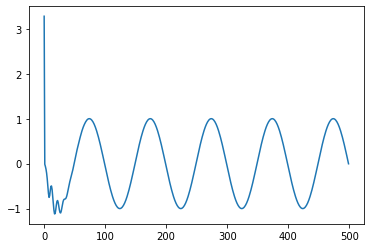

In [54]:
plt.plot(list(range(dt_fm.size))[:500], y_res[:500])

Показан спектр сигнала после демодуляции

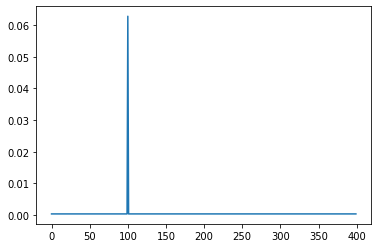

In [39]:
fft_fm_real = (2 / y_res.size) * np.abs(rfft(y_res))

plt.plot(mask_fm[:400], fft_fm_real[:400])